In this part, I am applying the first classification method, and DO NOT apply review count filtering.

The purpose of this part is to proof that my classification is reasonable and significant. To proof this point, I will feed my classified users' information to a logistic regression, and analyse the how much does my data fit into this model and how well my feeding features could explain the classes.

I will only feed two features, REVIEW COUNT and AVERAGE STARS. None of them contributed to the classification process. Therefore, as long as the classification result is relate to them, my classification is reasionable.

In [31]:
import datetime
import json
import numpy
from pandas.io.json import json_normalize
from time import time
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import scipy.stats as sp
from plotly import figure_factory as ff
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np
from scipy.stats import wald
import statsmodels.api as sm

In [6]:
df_user=pd.read_csv("yelp_academic_dataset_user.csv",encoding='latin-1') 

In [137]:
 df_user_class=pd.read_csv('wicoxon classification.csv',encoding='latin-1') 

In [424]:
 df_user_class=pd.read_csv('df_user_class_2.csv',encoding='latin-1') 

# Build up user features

In [3]:
def filter_user(df,n,m):
    return df[(df['review_count']>n )&(df['review_count']<m)]

In [4]:
len(df_user_class)

26351

## 1. Change yelping_since to number of years
The yelp dataset is due to 30th June 2017. Therefore, the yelping_age will be the number of year from yelping_since to 30th June 2017

In [7]:
df_user.yelping_since=pd.to_datetime(df_user.yelping_since) #Convert the yelping_since from str to date
end_date=datetime.datetime(2017,6,30) #Setup the end point of yelping
df_user['yelping_age']=end_date-df_user.yelping_since #Calculate users yelping age

## 2. Change friends to number of friends

In [138]:
def count_friends(row):
    return len(row.friends.split(','))

In [139]:
df_user['num_friends']=df_user.apply(lambda row: count_friends(row), axis=1)

## 3. change elite to several features

#### 1. change elite to number of times been elite

In [140]:
def count_elite(x):
    a=x.replace("'","").strip('[]').split(',')
    if a==['None']:
        return 0
    else:
        return len(a)

In [141]:
df_user['num_elite']=df_user.elite.apply(lambda x: count_elite(x))

## 4. user_ratings list

In [142]:
def ratings_list(x):
    a=x.replace("'","").strip('[]').split(',')
    return list(map(float,a))
        

In [143]:
df_user_class['ratings']=df_user_class.ratings.apply(lambda x: ratings_list(x))

AttributeError: 'DataFrame' object has no attribute 'ratings'

# match confidently taged users from all users

### df_tag_user1 contrarian users have:
1. more than 65% contrarian reviews 
2. overall more than 3 reviews

In [164]:
x=df_user_class.copy()
#x=df_user_class
del x['review_count'] #follow the review_count from the original dataset
del x['stars']
del x['cum_rating']
del x['Unnamed: 0']
df_tag_user1=pd.merge(left=x, right=df_user,how='left',on='user_id')
del df_tag_user1['type']
del df_tag_user1['Unnamed: 0']
del df_tag_user1['name']
del df_tag_user1['friends']
del df_tag_user1['elite']
#del df_tag_user1['average_stars']

In [148]:
x.user_class.value_counts()

0    15928
1    10423
Name: user_class, dtype: int64

In [165]:
df_tag_user1['yelping_since']=df_tag_user1.yelping_since.apply(lambda x: str(x))
df_tag_user1['yelping_age']=df_tag_user1.yelping_age.apply(lambda x: str(x))

# Try machine learning models to do classification

## 1. convert label encoding

In [166]:
data=df_tag_user1.ix[:, df_tag_user1.columns != 'user_class'].copy()
del data['user_id']
#one_hot_tag_user_1=pd.get_dummies(X,columns=X.columns)

In [167]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
for col in data.columns.values:
    if col=='ratings':
        continue
   # Encoding only categorical variables

    if data[col].dtypes=='O':
   # Using whole data to form an exhaustive list of levels
        le.fit(data[col].values)
        data[col]=le.transform(data[col])

In [13]:
df_user_class=pd.merge(left=df_user_class,right=df_user[['user_id','average_stars']],on='user_id',how='left')

In [168]:
len(df_user_class)

26351

# Logistic Regression

In [153]:

from numpy import *

def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.

    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.

    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.

    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])

    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in range(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [173]:
train_cols=data.columns

In [156]:
data.average_stars=data.average_stars.apply(lambda x: round(x) )

In [171]:
df=data

In [105]:
#dummy_ranks = pd.get_dummies(df['average_stars'], prefix='average_stars')
cols_to_keep=['user_class','review_count']
data = df_user_class[cols_to_keep].join(dummy_ranks.ix[:, 'average_stars_1.0':])

In [99]:
min(data.review_count)

21

In [57]:
data['intercept']=1.0

In [106]:
data.review_count = data.review_count.map(np.log10)

In [107]:
min(data.review_count)

1.3222192947339193

In [174]:
#train_cols = data.columns[1:]
# Index([gre, gpa, prestige_2, prestige_3, prestige_4], dtype=object)

logit = sm.Logit(df_tag_user1['user_class'], data[train_cols])

# fit the model
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.669385
         Iterations 7


In [175]:
print (result.summary())

                           Logit Regression Results                           
Dep. Variable:             user_class   No. Observations:                26351
Model:                          Logit   Df Residuals:                    26331
Method:                           MLE   Df Model:                           19
Date:                Sat, 26 Aug 2017   Pseudo R-squ.:                0.002650
Time:                        19:36:17   Log-Likelihood:                -17639.
converged:                       True   LL-Null:                       -17686.
                                        LLR p-value:                 7.185e-12
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
average_stars         -0.1592      0.012    -13.566      0.000        -0.182    -0.136
compliment_cool     4.879e-05   1.27e+11   3.84e-16      1.000     -2.49e+11  2.49e+11
compliment_cute     

In [110]:
exp(result.params).reset_index()

,index,0
0,review_count,6.731896
1,average_stars_2,2.194064
2,average_stars_3,0.053966
3,average_stars_4,0.019874
4,average_stars_5,1.190664


In [65]:
print (result.conf_int())

                            0             1
review_count     7.832431e-01  8.716758e-01
average_stars_2 -1.140170e+06  1.140056e+06
average_stars_3 -1.140174e+06  1.140052e+06
average_stars_4 -1.140175e+06  1.140051e+06
average_stars_5 -1.140171e+06  1.140055e+06
intercept       -1.140055e+06  1.140171e+06


In [111]:
import pandas as pd
import scipy.stats as scs
from scipy.stats import chi2_contingency


def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]

    return scs.chi2_contingency(result)
chi_square_of_df_cols(df,'user_class','average_stars')

(2651.2063761647169,
 0.0,
 4,
 array([[  4.23118667e+00,   2.01283595e+02,   3.95253281e+03,
           1.12144580e+04,   5.55494365e+02],
        [  2.76881333e+00,   1.31716405e+02,   2.58646719e+03,
           7.33854195e+03,   3.63505635e+02]]))

In [112]:
review_c = np.linspace(data['review_count'].min(), data['review_count'].max(), 10)
pd.DataFrame(cartesian([review_c, [1, 2, 3, 4,5], [1.]]))


/Users/stevezhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

/Users/stevezhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



,0,1,2
0,1.322219,1.0,1.0
1,1.322219,2.0,1.0
2,1.322219,3.0,1.0
3,1.322219,4.0,1.0
4,1.322219,5.0,1.0
5,1.548516,1.0,1.0
6,1.548516,2.0,1.0
7,1.548516,3.0,1.0
8,1.548516,4.0,1.0
9,1.548516,5.0,1.0


In [77]:
combos

,review_c,average_stars,intercept,average_stars_1.0,average_stars_2.0,average_stars_3.0,average_stars_4.0,average_stars_5.0
0,0.000000,1.0,1.0,1,0,0,0,0
1,0.000000,2.0,1.0,0,1,0,0,0
2,0.000000,3.0,1.0,0,0,1,0,0
3,0.000000,4.0,1.0,0,0,0,1,0
4,0.000000,5.0,1.0,0,0,0,0,1
5,0.859347,1.0,1.0,1,0,0,0,0
6,0.859347,2.0,1.0,0,1,0,0,0
7,0.859347,3.0,1.0,0,0,1,0,0
8,0.859347,4.0,1.0,0,0,0,1,0
9,0.859347,5.0,1.0,0,0,0,0,1


In [80]:
combos

,review_count,average_stars,intercept,average_stars_1.0,average_stars_2.0,average_stars_3.0,average_stars_4.0,average_stars_5.0
0,0.000000,1.0,1.0,1,0,0,0,0
1,0.000000,2.0,1.0,0,1,0,0,0
2,0.000000,3.0,1.0,0,0,1,0,0
3,0.000000,4.0,1.0,0,0,0,1,0
4,0.000000,5.0,1.0,0,0,0,0,1
5,0.859347,1.0,1.0,1,0,0,0,0
6,0.859347,2.0,1.0,0,1,0,0,0
7,0.859347,3.0,1.0,0,0,1,0,0
8,0.859347,4.0,1.0,0,0,0,1,0
9,0.859347,5.0,1.0,0,0,0,0,1


In [81]:
train_cols

Index(['review_count', 'average_stars_2', 'average_stars_3', 'average_stars_4',
       'average_stars_5', 'intercept'],
      dtype='object')

In [113]:
review_c = np.linspace(data['review_count'].min(), data['review_count'].max(), 10)

combos = pd.DataFrame(cartesian([review_c, [1, 2, 3, 4,5], [1.]]))
# recreate the dummy variables
combos.columns = [ 'review_count', 'average_stars', 'intercept']
dummy_ranks = pd.get_dummies(combos['average_stars'], prefix='average_stars')
dummy_ranks.columns = ['average_stars_1', 'average_stars_2', 'average_stars_3', 'average_stars_4','average_stars_5']

# keep only what we need for making predictions
cols_to_keep = [ 'review_count', 'average_stars', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'average_stars_1.0':])

# make predictions on the enumerated dataset
combos['user_class_pre'] = result.predict(combos[train_cols])

print (combos.head())


   review_count  average_stars  intercept  average_stars_2  average_stars_3  \
0      1.322219            1.0        1.0                0                0   
1      1.322219            2.0        1.0                1                0   
2      1.322219            3.0        1.0                0                1   
3      1.322219            4.0        1.0                0                0   
4      1.322219            5.0        1.0                0                0   

   average_stars_4  average_stars_5  user_class_pre  
0                0                0        0.925620  
1                0                0        0.964669  
2                0                0        0.401763  
3                1                0        0.198287  
4                0                1        0.936778  


/Users/stevezhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:49: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future

/Users/stevezhang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning:

using a non-integer number instead of an integer will result in an error in the future



In [129]:
combos.review_count=combos.review_count.apply(lambda x:10**x)

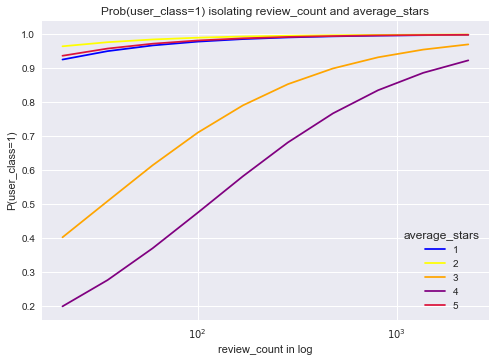

In [133]:
import seaborn
def isolate_and_plot(variable):
    # isolate gre and class rank
    grouped = pd.pivot_table(combos, values=['user_class_pre'], index=[variable, 'average_stars'],
                            aggfunc=np.mean)
    
    # in case you're curious as to what this looks like
    # print grouped.head()
    #                      admit_pred
    # gre        prestige            
    # 220.000000 1           0.282462
    #            2           0.169987
    #            3           0.096544
    #            4           0.079859
    # 284.444444 1           0.311718
    
    # make a plot
    colors = ['red','blue','yellow','orange','purple','crimson']
    for col in combos.average_stars.unique():
        plt_data = grouped.ix[grouped.index.get_level_values(1)==col]
        pl.plot(plt_data.index.get_level_values(0), plt_data['user_class_pre'],
                color=colors[int(col)])
    
    pl.xlabel(variable+' in log')
    pl.ylabel("P(user_class=1)")
    pl.legend(['1', '2', '3', '4','5'], loc='lower right', title='average_stars')
    pl.title("Prob(user_class=1) isolating " + variable + " and average_stars")
    pl.xscale('log')
    pl.show()

isolate_and_plot('review_count')


In [118]:
10**(2)

100

In [40]:
#FIT ROC ：http://blog.yhat.com/posts/roc-curves.html
from sklearn import metrics
import pandas as pd
from ggplot import *

preds = clf.predict_proba(Xtest)[:,1]
fpr, tpr, _ = metrics.roc_curve(ytest, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed')

NameError: name 'clf' is not defined